In [1]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../src/')
from diffusion import DiffusionModel
from evaluate import get_results
from omegaconf import OmegaConf
from main import load_data, make_model
import numpy as np
import os
import glob
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import torch

In [2]:
# Initialize wandb (replace 'your_entity' and 'your_project' with your specific details)
wandb.login()
api = wandb.Api()

# Specify your entity, project, and sweep ID
entity = "xingzhis"
project = "dmae"
sweep_id = '85a418h7'

# Fetch the sweep
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

run_ids = [run.id for run in sweep.runs]

run_id = '2tyxnsdk'
run = [run for run in sweep.runs if run.id == run_id][0]

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: xingzhis. Use `wandb login --relogin` to force relogin


In [3]:
cfg = OmegaConf.create(run.config)
folder_path = "../src/wandb/"
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]

In [4]:
diffusionmodel = DiffusionModel.load_from_checkpoint(
    checkpoint_path=ckpt_path,
    data_size=10, 
    time_embedding_size=cfg.time_embedding_size,
    layer_widths=cfg.layer_widths,
    dropout=cfg.dropout,
    batch_norm=cfg.batch_norm,
    num_steps=cfg.num_steps,
    learning_rate=cfg.lr,
    weight_decay=cfg.weight_decay,
)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


In [5]:
dat = np.load('../dm_data/eb_all_new.npz')

In [6]:
# data_pred = x_pred[~train_mask]
# latent_pred = z_pred[~train_mask]
train_mask = dat['train_mask']
with torch.no_grad():
    generated_latent = diffusionmodel.generate_samples((~train_mask).sum())

In [7]:
data_latent = np.load(cfg.path + cfg.data)
data_latent_train = data_latent['data'][data_latent['train_mask']]
mean_, std_ = np.mean(data_latent_train, axis=0), np.std(data_latent_train, axis=0)

In [8]:
mean_

array([ -1.4849229,  -2.3523974, -12.951983 ,  -5.2744513, -12.529911 ,
        -8.038555 ,  -3.893584 ,  -1.1391155, -14.521694 ,   3.7268803],
      dtype=float32)

In [9]:
std_

array([11.317914, 17.024483, 18.447636, 16.287455, 17.16799 , 22.406199,
       16.636932, 13.362559, 17.359678, 16.05057 ], dtype=float32)

In [10]:
generated_latent

tensor([[-4.0577, -5.0930,  1.4256,  ...,  5.3981, -4.8937, -3.0514],
        [-0.0348,  0.7117,  0.4614,  ..., -0.5488,  0.2795,  0.2517],
        [ 0.8092, -2.3598, -5.0052,  ...,  0.2162, -3.5779,  1.3530],
        ...,
        [-0.6474,  0.7857,  0.6220,  ..., -0.3570,  0.8459,  0.0063],
        [ 0.2597,  0.5431, -0.0881,  ..., -0.3564,  1.2351,  0.5817],
        [ 1.5587,  0.7404,  0.0408,  ..., -0.4169,  0.8843,  0.6137]])

In [11]:
generated_latent = generated_latent * std_ + mean_

In [12]:
generated_latent

tensor([[ -47.4092,  -89.0587,   13.3470,  ...,   70.9930,  -99.4744,
          -45.2504],
        [  -1.8785,    9.7635,   -4.4395,  ...,   -8.4720,   -9.6699,
            7.7663],
        [   7.6731,  -42.5264, -105.2861,  ...,    1.7505,  -76.6337,
           25.4437],
        ...,
        [  -8.8127,   11.0230,   -1.4779,  ...,   -5.9098,    0.1636,
            3.8275],
        [   1.4548,    6.8935,  -14.5764,  ...,   -5.9011,    6.9185,
           13.0628],
        [  16.1562,   10.2524,  -12.2000,  ...,   -6.7100,    0.8291,
           13.5778]])

In [13]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot

In [14]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
latent_gen = generated_latent.detach().cpu().numpy()
latent_test = data_latent['data'][~data_latent['train_mask']]
latent_train = data_latent['data'][data_latent['train_mask']]

In [16]:
def compute_w2(gen, tru):
    M = ot.dist(gen, tru)
    M = torch.tensor(M, dtype=torch.float32, device=device)
    # M/=M.max()
    n = latent_test.shape[0]
    a, b = torch.ones((n,)).to(device) / n, torch.ones((n,)).to(device) / n  # uniform distribution on samples
    G0 = ot.emd(a, b, M)
    W = torch.sum(G0 * M)
    return torch.sqrt(W)

In [17]:
std = latent_train.std()
noises = np.arange(1, 10) * 0.1
w2s = []
for noise in noises:
    noisy_test = latent_test + np.random.randn(*latent_test.shape) * noise * std
    w2 = compute_w2(noisy_test, latent_test).detach().cpu().numpy()
    w2s.append(w2)

In [18]:
latent_train.mean(axis=0).shape

(10,)

In [19]:
latent_train.shape

(2400, 10)

In [20]:
mean = latent_train.mean(axis=0)
cov = np.cov(latent_train, rowvar=False)
rand_samples = np.random.multivariate_normal(mean, cov, latent_test.shape[0])

In [21]:
res = np.array([noises, w2s]).T
w_rand = compute_w2(rand_samples, latent_test).cpu().numpy()
w_gen = compute_w2(latent_gen, latent_test).cpu().numpy()

Text(0, 0.5, 'w2')

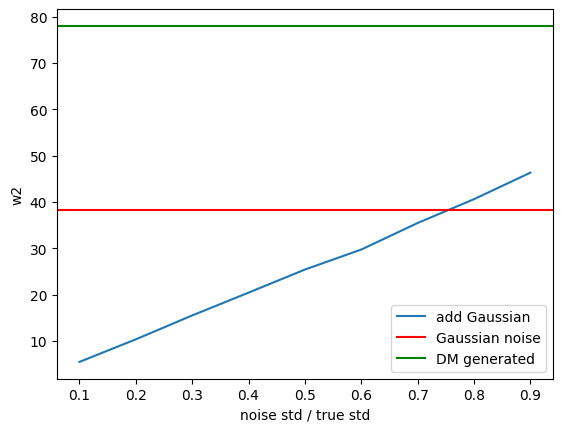

In [22]:
fig, ax = plt.subplots()
ax.plot(res[:,0], res[:,1], label='add Gaussian')
ax.axhline(y=w_rand, color='r', linestyle='-', label='Gaussian noise')
ax.axhline(y=w_gen, color='g', linestyle='-', label='DM generated')
ax.legend()
ax.set_xlabel('noise std / true std')
ax.set_ylabel('w2')

In [23]:
latent_gen

array([[ -47.40921   ,  -89.05872   ,   13.346992  , ...,   70.99302   ,
         -99.474396  ,  -45.25036   ],
       [  -1.8784974 ,    9.763525  ,   -4.439459  , ...,   -8.471993  ,
          -9.669914  ,    7.7662954 ],
       [   7.673122  ,  -42.52636   , -105.28606   , ...,    1.7504765 ,
         -76.63367   ,   25.443731  ],
       ...,
       [  -8.812674  ,   11.022978  ,   -1.4779139 , ...,   -5.9098253 ,
           0.16358471,    3.8274786 ],
       [   1.4548433 ,    6.893451  ,  -14.57638   , ...,   -5.9010706 ,
           6.918535  ,   13.062752  ],
       [  16.156214  ,   10.252443  ,  -12.199984  , ...,   -6.7099648 ,
           0.82906437,   13.57779   ]], dtype=float32)

In [24]:
latent_test

array([[  9.800569  ,   2.0030339 , -11.743625  , ...,  -0.7008156 ,
          0.35308194,   2.3554165 ],
       [  7.186719  ,   8.19127   , -20.614239  , ...,  -5.0256166 ,
         -0.24727951,  13.8656645 ],
       [  5.507631  ,   6.2525024 , -27.013517  , ...,  -4.843895  ,
         -0.6470086 ,  19.063032  ],
       ...,
       [  7.173453  ,   7.031463  , -19.050034  , ...,  -4.8250866 ,
          1.0848899 ,  13.089113  ],
       [-12.201614  ,  -8.274226  ,  -1.0593556 , ...,  17.958363  ,
        -22.340244  , -29.251005  ],
       [ -4.902991  ,  -2.253387  ,  -4.0954623 , ..., -11.04633   ,
        -11.564161  ,   7.8321605 ]], dtype=float32)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: >

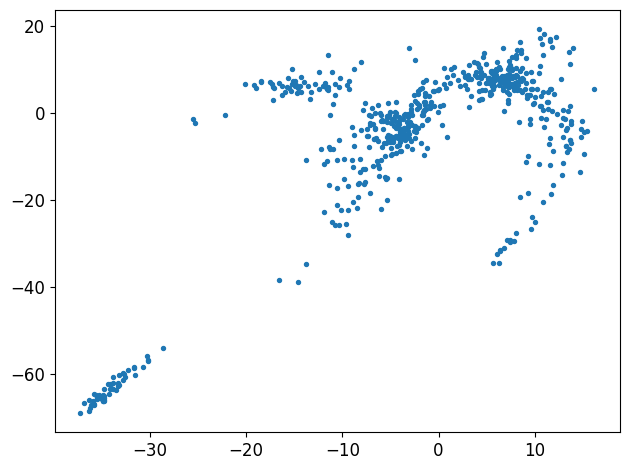

In [25]:
scprep.plot.scatter2d(latent_test)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: >

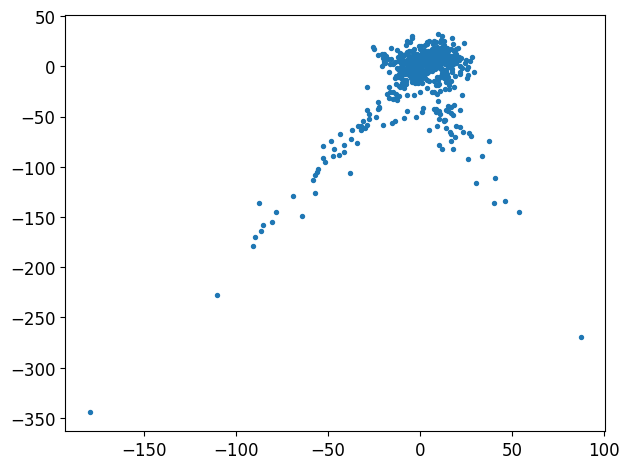

In [26]:
scprep.plot.scatter2d(latent_gen)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: >

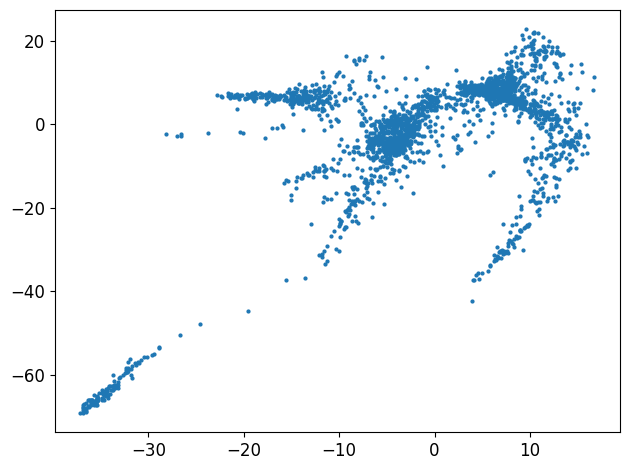

In [27]:
scprep.plot.scatter2d(latent_train)

In [28]:
assert False
data = np.load('../data/eb_all.npz')

AssertionError: 

In [ ]:
import phate

: 

In [ ]:
phate_op = phate.PHATE(knn=4, decay=15, t=12, n_jobs=-2, n_components=10)

: 

In [ ]:
x_phate = phate_op.fit_transform(data['data'])

: 

In [ ]:
x_phate

: 

In [ ]:
scprep.plot.scatter2d(x_phate)

: 

In [ ]:
from scipy.spatial.distance import pdist, squareform

: 

In [ ]:
distpp = squareform(pdist(phate_op.diff_potential))

: 

In [ ]:
distp = squareform(pdist(x_phate))

: 

In [ ]:
distd = squareform(pdist(data_latent['data']))

: 

In [ ]:
distpp

: 

In [ ]:
distp

: 

In [ ]:
distd

: 

In [ ]:
data['dist']

: 

: 